In [389]:
from torch.utils.data import Dataset
import torch
import pandas as pd
import os
import numpy as np
import glob
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data.dataset import T_co

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [390]:
train_root = "Data/train"
test_root = "Data/test"
train_csv = "Data/train.csv"
classes = np.array(["shsy5y", "astro", "cort"])

In [391]:
def process_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.set_index('id')
    annotations = df.groupby(['id'])['annotation'].transform(
        lambda x: ' '.join(x)).drop_duplicates()
    types = df.groupby(['id'])['cell_type'].unique()
    return annotations.to_frame().join(types)

def reconstruct_annotations_image(annotations, height, width) -> np.array:
    annotations = np.array(annotations.split(" ")).astype(int)
    image = np.zeros(shape=(height * width))
    for i in np.arange(0, len(annotations), 2):
        begin = annotations[i]
        length = annotations[i+1] - 1
        image[begin: begin+length] = 1
    return image.reshape(height, width)

def ToTensor(sample):
    image, ann_image, label = sample['image'], sample['annotation'], sample["label"]
    # swap color axis because
    # numpy image: H x W x C
    # torch image: C x H x W
    image = image.transpose((2, 0, 1))
    ann_image = ann_image.transpose((2, 0, 1))
    return {'image': torch.from_numpy(image),
            'annotation': torch.from_numpy(ann_image),
            'label': label}

class CellsAnnTrainDataSet(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.df = None
        df = pd.read_csv(csv_file)
        self.df = process_df(df)
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        image_id = self.df.iloc[index].name
        image_name = f"{image_id}.png"
        image_path = os.path.join(self.root_dir, image_name)
        image = plt.imread(image_path)[:,:,np.newaxis]
        width, height = image.shape[:2]
        annotations = self.df.iloc[index]['annotation']
        ann_image = reconstruct_annotations_image(annotations, width, height)[:,:,np.newaxis]
        cell_type = self.df.iloc[index]['cell_type']
        if self.transform is not None:
            image = self.transform(image)
        return ToTensor({'image': image, "annotation": ann_image,
                         "label": np.where(classes == cell_type)})


class CellClassificationTrainDataSet(Dataset):
    def __init__(self):

    def __getitem__(self, index) -> T_co:
        pass


class CellsTestDataSet(Dataset):
    def __init__(self, root_dir):
        self.images = glob.glob(root_dir + "/*.png")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = plt.imread(self.images[index])
        return image[np.newaxis,:,:]




In [392]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5),
     transforms.RandomAutocontrast(),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(90),
     transforms.RandomErasing(),
     transforms.RandomVerticalFlip(),
     transforms.RandomAdjustSharpness(1),
     transforms.RandomResizedCrop(size=(520, 704))
     ])

train_set = CellsTrainDataSet(train_root, train_csv, )
test_set = CellsTestDataSet(test_root)
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=3, shuffle=False)

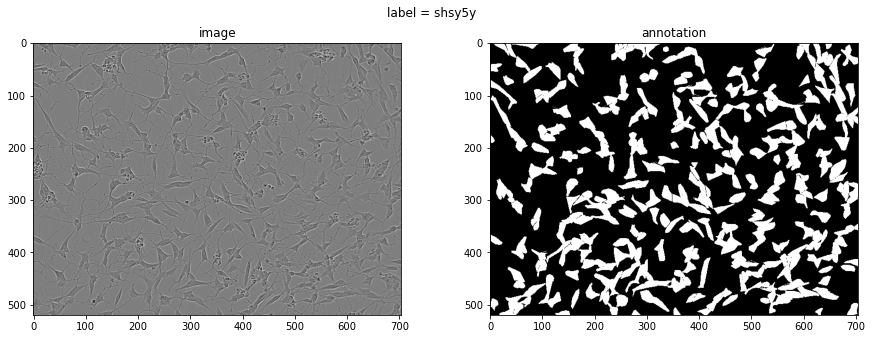

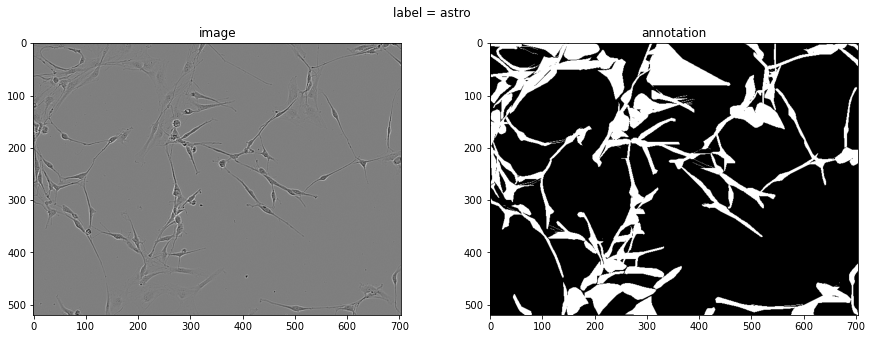

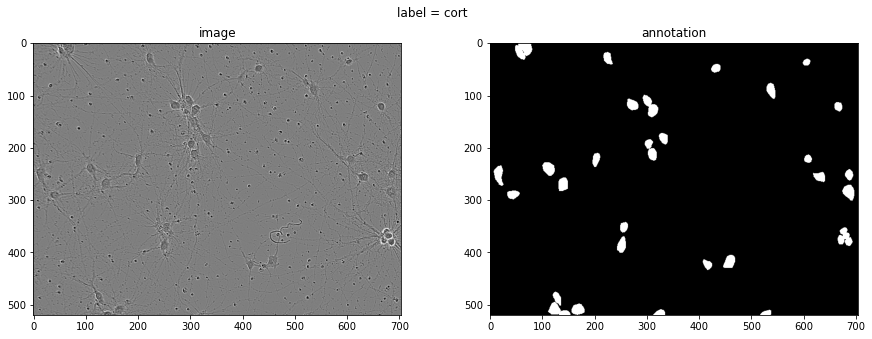

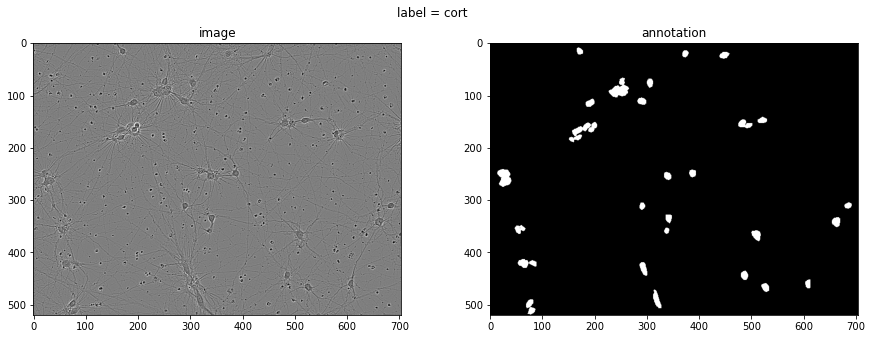

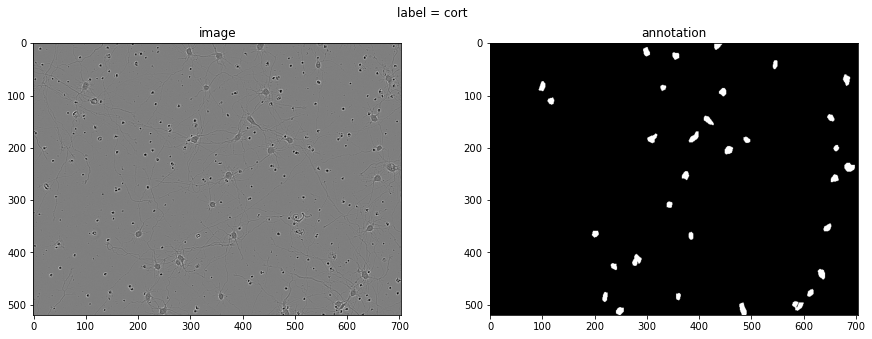

In [400]:
# draw some images:
for i in range(5):
    sample = train_set[i]
    image = sample['image']
    annotation = sample['annotation']
    fig = plt.figure(figsize=(15,5))
    ax = fig.subplots(ncols=2)
    ax[0].imshow(image.squeeze(), cmap='gray')
    ax[1].imshow(annotation.squeeze(), cmap='gray')
    ax[0].set_title("image")
    ax[1].set_title("annotation")
    fig.suptitle(f"label = {classes[sample['label'][0][0]]}")
    plt.show()

<AxesSubplot:>

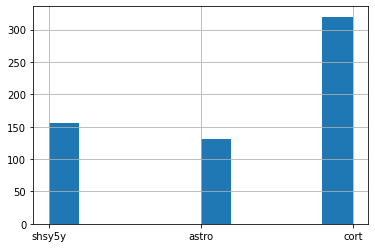

In [394]:
# analyze data balance:
df = pd.read_csv(train_csv)
df.drop_duplicates(['id'])['cell_type'].hist()

In [401]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size = (3,3)):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2))
        )
        self.to(device)

    def forward(self, x):
        x.to(device)
        return self.layers(x)

class CellClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            ConvBlock(1, 2),
            ConvBlock(2,4),
            ConvBlock(4,8),
            ConvBlock(8,16),
            nn.Flatten(),
            nn.Linear(20160, 512),
            nn.Linear(512, 3),
            nn.Softmax(dim=1)
        )
        self.to(device)


    def forward(self, x):
        x.to(device)
        for layer in self.layers:
            x = layer(x)
        return x

    def run_training(self, train_loader, epochs):
        criterion = nn.CrossEntropyLoss(weight=torch.tensor([.4,.4,.2]).to(device))
        optimizer = optim.Adam(self.parameters(), lr=0.0001)
        for epoch in range(1, epochs+1):  # loop over the dataset multiple times
            running_loss = 0.0
            for i, data in enumerate(train_loader, 0):
                # get the inputs; data is a list of [inputs, labels]
                image, labels = data['image'].to(device), data['label']
                labels = torch.tensor([t.numpy() for t in labels])
                labels = labels.reshape(labels.size(1)).to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self(image)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 10 == 9:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch, i + 1, running_loss / 2000))
                    running_loss = 0.0

        print('Finished Training')

classifier = CellClassifier()
classifier.run_training(train_loader, 20)

[1,    10] loss: 0.006
[1,    20] loss: 0.006
[1,    30] loss: 0.005
[2,    10] loss: 0.005
[2,    20] loss: 0.005
[2,    30] loss: 0.005
[3,    10] loss: 0.005
[3,    20] loss: 0.005
[3,    30] loss: 0.005
[4,    10] loss: 0.005
[4,    20] loss: 0.005
[4,    30] loss: 0.005
[5,    10] loss: 0.005
[5,    20] loss: 0.005
[5,    30] loss: 0.005
[6,    10] loss: 0.004
[6,    20] loss: 0.005
[6,    30] loss: 0.005
[7,    10] loss: 0.004
[7,    20] loss: 0.005
[7,    30] loss: 0.005
[8,    10] loss: 0.005
[8,    20] loss: 0.005
[8,    30] loss: 0.005
[9,    10] loss: 0.005
[9,    20] loss: 0.004
[9,    30] loss: 0.004
[10,    10] loss: 0.004
[10,    20] loss: 0.004
[10,    30] loss: 0.004
[11,    10] loss: 0.004
[11,    20] loss: 0.005
[11,    30] loss: 0.004
[12,    10] loss: 0.004
[12,    20] loss: 0.004
[12,    30] loss: 0.005
[13,    10] loss: 0.005
[13,    20] loss: 0.004
[13,    30] loss: 0.004
[14,    10] loss: 0.004
[14,    20] loss: 0.004
[14,    30] loss: 0.004
[15,    10] loss: 0

In [402]:
with torch.no_grad():
    for data in test_loader:
        output = classifier(data.to(device))
        print(output)

tensor([[1.5802e-23, 0.0000e+00, 1.0000e+00],
        [1.0000e+00, 1.4519e-30, 3.9838e-11],
        [3.0844e-01, 6.6040e-33, 6.9156e-01]], device='cuda:0')


In [397]:
class AnnotationConstructor(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = None
        self.astroConstructor = None
        self.cortConstructor = None
        self.shsy5yConstructor = None